### Best theta channel

In [ ]:
import subjects
from neuropy.analyses.oscillations import detect_theta_epochs

sessions = subjects.sd.ratSday3

for sess in sessions:
    maze = sess.paradigm['maze'].flatten()
    prb = sess.probegroup
    signal = sess.eegfile.get_signal(t_start=maze[0],t_stop=maze[1])
    theta_epochs = detect_theta_epochs(signal=signal,probegroup=prb) 
    theta_epochs.save(sess.filePrefix.with_suffix('.theta.epochs'))

In [ ]:
sess.recinfo.write_epochs(theta_epochs,ext='.the')

### Theta modulation index during MAZE
- Exact calculation and testing done here

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.utils import neurons_util
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter1d
import subjects

sessions = subjects.nsd.ratUday2

In [ ]:
%matplotlib widget
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    maze_neurons = (
        sess.neurons.get_neuron_type("pyr")
        .time_slice(maze[0], maze[1])
        .get_above_firing_rate(0.05)
    )
    acg = neurons_util.calculate_neurons_acg(
        maze_neurons, bin_size=0.001, window_size=0.5
    )
    acg_right = acg[:, acg.shape[1] // 2 :]
    trough, peak = (acg_right[:, 50:70]).sum(axis=1), (acg_right[:, 100:140]).sum(
        axis=1
    )
    tmi = (peak - trough) / (peak + trough)

    norm_acg_ = stats.zscore(acg, axis=1)
    norm_acg = gaussian_filter1d(stats.zscore(acg, axis=1), sigma=2)
    # norm_acg = stats.zscore(acg,axis=1)

    sort_ind = np.argsort(tmi)
    plt.pcolormesh(norm_acg[sort_ind, 250:], cmap="jet")


### How does theta modulated cells behave during sleep deprivation
- do they decrease their firing rate during SD more than non-theta modulated cells

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.utils import neurons_util
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sd_sessions = subjects.sd.ratNday1+subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions = subjects.nsd.ratNday2+subjects.nsd.ratSday2 + subjects.nsd.ratUday2

In [ ]:
bin_size = 15*60
nQuantiles = 5

theta_mod_frate = pd.DataFrame()
for grp, sessions in zip(['sd','nsd'],[sd_sessions,nsd_sessions]):
    post_frate=[]
    quantiles=[]
    for sub, sess in enumerate(sessions):
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm['post'].flatten()
        maze_neurons = (
            sess.neurons.get_neuron_type("pyr")
            .time_slice(maze[0], maze[1])
            .get_above_firing_rate(0.05)
        )
        acg = neurons_util.calculate_neurons_acg(maze_neurons, bin_size=0.001, window_size=0.5)
        acg_right = acg[:, acg.shape[1] // 2 :]
        trough, peak = (acg_right[:, 50:70]).sum(axis=1), (acg_right[:, 100:140]).sum(
            axis=1
        )
        tmi = (peak - trough) / (peak + trough)
        quantiles.append(pd.qcut(tmi, q=nQuantiles, labels=False))
        neuron_ids_bool = np.isin(sess.neurons.neuron_ids,maze_neurons.neuron_ids)
        binspk = sess.neurons[neuron_ids_bool].time_slice(
                    post[0], post[0] + 9 * 3600
                ).get_binned_spiketrains(bin_size=bin_size)
        post_frate.append(binspk.spike_counts/bin_size)

    quantiles = np.concatenate(quantiles)
    post_frate = np.vstack(post_frate)
    assert len(quantiles) == post_frate.shape[0],'First dimension should match'

    quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
    quant_mean_frate = np.asarray(quant_mean_frate)
    first_bin = quant_mean_frate[:, 0]
    quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

    df = pd.DataFrame(
        quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
    )
    df["grp"] = grp
    df["quantiles"] = np.arange(nQuantiles)
    theta_mod_frate = theta_mod_frate.append(df)

theta_mod_frate= pd.melt(
    theta_mod_frate,
    id_vars=["grp", "quantiles"],
    value_vars=np.arange(36),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

theta_mod_frate['bins'] = theta_mod_frate['bins']*(bin_size/3600)


In [ ]:
%matplotlib widget
import seaborn as sns
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw(grid=(3,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs[i])
    df = theta_mod_frate[(theta_mod_frate["grp"] == grp)]
    
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
        ax=ax_1v5
    )   
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.25,top=1.6)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    # if i==0:
        # figure.panel_label(ax_1v5,'E')

ax_caption = plt.subplot(gs[1, :])
ax_caption.text(
    0,
    0,
    "Figure: Five percentiles firing rate ratio plotted in first 5h of POST. Percentiles were calculated based on theta modulation index (TMI) i.e, the difference between the theta modulation trough (defined as mean of autocorrelogram bins, 50–70 msec) and the theta modulation peak (mean of autocorrelogram bins, 100–140 msec) over their sum (Cacucci et al. 2004). Darker color represent higher theta modulation.",
    wrap=True,
)
ax_caption.axis("off")
fig.suptitle('Firing rate in POST of theta modulated cells (frate thresh = 0.05)')
figure.savefig(subjects.figpath_sd/'theta_modulation_frate_POST')

### Theta modulated cells and their firing rate scatter plot during SD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.utils import neurons_util
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sd_sessions = subjects.sd.ratNday1+subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions = subjects.nsd.ratNday2+subjects.nsd.ratSday2 + subjects.nsd.ratUday2

In [ ]:
bin_size = 15 * 60
nQuantiles = 5

theta_mod_frate = {}
for grp, sessions in zip(["sd", "nsd"], [sd_sessions, nsd_sessions]):
    post_frate,tmi_all,maze_frate = [],[],[]
    for sub, sess in enumerate(sessions):
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm["post"].flatten()
        maze_neurons = (
            sess.neurons.get_neuron_type("pyr")
            .time_slice(*maze)
            .get_above_firing_rate(0.05)
        )
        tmi = neurons_util.theta_modulation_index(maze_neurons,sigma=2)
        tmi = np.around(tmi,3)

        maze_frate.append(maze_neurons.firing_rate)
        neuron_ids_bool = np.isin(sess.neurons.neuron_ids, maze_neurons.neuron_ids)
        binspk = (
            sess.neurons[neuron_ids_bool]
            .time_slice(post[0], post[0] + 9 * 3600)
            .get_binned_spiketrains(bin_size=bin_size)
        )
        # frate_ =binspk.spike_counts/bin_size
        # first_bin = frate_[:,0]
        # norm_frate = frate_ / first_bin[:, np.newaxis]

 
        post_frate.append(binspk.spike_counts / bin_size)
        # post_frate.append(norm_frate)
        tmi_all.append(tmi)

    tmi_all = np.concatenate(tmi_all)
    post_frate = np.vstack(post_frate)
    theta_mod_frate[grp] = {'tmi':tmi_all,'frate':post_frate,'maze_frate':np.concatenate(maze_frate)}


In [ ]:
%matplotlib inline
import seaborn as sns
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from palettable.colorbrewer.qualitative import Paired_12
from neuropy.utils.mathutil import min_max_scaler
from neuropy.plotting import Fig
from matplotlib import cm
from neuropy.plotting.figure import Colormap

figure = Fig()
fig,gs = figure.draw(grid=(3,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax = plt.subplot(gs[i,:])
    df = theta_mod_frate[grp]

    tmi,frate,maze_frate = df['tmi'],df['frate'],df['maze_frate']
    cmap = cm.get_cmap('Dark2')
    # tmi = min_max_scaler(tmi)
    print(np.nanmin(tmi),np.nanmax(tmi))
    colors = cmap(tmi)

    s1 = pd.Series(tmi)
    corr = []
    for i1 in range(frate.shape[1]):
        x_coord =i1* np.ones(len(tmi))+ np.random.randn(len(tmi))*0.15
        x_coord *= 0.25
        sc = ax.scatter(x_coord,frate[:,i1],c=tmi,s=1.2,cmap=Colormap().dynamic4())
        corr.append(s1.corr(pd.Series(stats.zscore(frate[:,i1]))))

    ax.spines['right'].set_visible(True)
    cb = plt.colorbar(sc,location='left')
    cb.outline.set_visible(False)
    cb.ax.set_ylabel('Theta modulation index')
    ax.set_yscale('log')
    ax.set_ylabel('Firing rate (Hz)')
    ax.set_xlabel('Zt time (h)')
    ax.set_title(grp)

    ax2 = ax.twinx() 
    ax2.plot(np.arange(len(corr))*0.25,corr,'k')
    ax2.set_ylabel('Correlation (TMI vs firing rate)')
    
ax_caption = plt.subplot(gs[2, :])
ax_caption.text(
    0,
    0,
    "Figure: Firing rate distribution in each 15 minute window, colored by theta modulation index (TMI) i.e, the difference between the theta modulation trough (defined as mean of autocorrelogram bins, 50–70 msec) and the theta modulation peak (mean of autocorrelogram bins, 100–160 msec) over their sum (Cacucci et al. 2004). Darker color represent higher theta modulation.",
    wrap=True,
)
ax_caption.axis("off")
fig.suptitle('Firing rate in POST of theta modulated cells (frate thresh = 0.05)')
# figure.savefig(subjects.figpath_sd/'theta_modulation_frate_distribution_POST')

### Firing rate correlation coefficient and connecting that to TMI
- So some firing rate analysis revealed that during sleep deprivation neurons increase their firing rate. But do all neurons do that or is their a differential effect on neurons based on some criteria. Here in this analysis I tried to look into the relationship between theta modulation index during MAZE and firing rate trend during first 5h of POST.
- Firing rate trend was calculated by binning firing rate in 10 minutes time window and calculating firing rate correlation-coefficient over time. This was then compared to theta modulation index during maze.  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.utils import neurons_util
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sd_sessions = subjects.sd.ratNday1+subjects.sd.ratSday3 + subjects.sd.ratUday4 
nsd_sessions = subjects.nsd.ratNday2+subjects.nsd.ratSday2 + subjects.nsd.ratUday2

In [ ]:
sd_sessions[0].neurons.waveforms_amplitude

In [ ]:
from neuropy.analyses import neurons_stability
bin_size = 10 * 60
nQuantiles = 5

theta_mod_frate_corr = {}
for grp, sessions in zip(["sd", "nsd"], [sd_sessions, nsd_sessions]):
    tmi_all, corr, acg_all, frate_all = [], [], [], []
    for sub, sess in enumerate(sessions):
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm["post"].flatten()
        neurons = sess.neurons.get_neuron_type("pyr")
        # neurons_stable_bool = neurons_stability.firing_rate_stability(
        #         neurons=neurons,window=2*3600
        #     )
        # neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

        maze_neurons = neurons.time_slice(*maze).get_above_firing_rate(0.01)
        tmi, acg = neurons_util.theta_modulation_index(
            maze_neurons, sigma=2, return_acg=True
        )
        tmi = np.around(tmi, 4)

        binspk = (
            neurons.get_by_id(maze_neurons.neuron_ids)
            .time_slice(post[0], post[0] + 5 * 3600)
            .get_binned_spiketrains(bin_size=bin_size)
        )

        zsc_post_frate = stats.zscore(binspk.firing_rate, axis=1)
        post_frate_with_time = np.vstack((binspk.time.reshape(1, -1), zsc_post_frate))
        frate_corr_with_time = np.corrcoef(post_frate_with_time)[0, 1:]

        tmi_all.append(tmi)
        corr.append(frate_corr_with_time)
        acg_all.append(stats.zscore(acg,axis=1))
        frate_all.append(zsc_post_frate)

    tmi_all = np.concatenate(tmi_all)
    corr = np.concatenate(corr)
    acg_all = np.vstack(acg_all)
    frate_all = np.vstack(frate_all)
    theta_mod_frate_corr[grp] = {
        "tmi": tmi_all,
        "corr": corr,
        "acg": acg_all,
        "frate": frate_all,
    }


In [ ]:
%matplotlib widget
import seaborn as sns
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from palettable.colorbrewer.qualitative import Paired_12
from neuropy.utils.mathutil import min_max_scaler
from neuropy.plotting import Fig
from matplotlib import cm
from neuropy.plotting.figure import Colormap

figure = Fig()
fig, gs = figure.draw(grid=(3, 2),hspace=0.3)
colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]

sd_corr = theta_mod_frate_corr['sd']['corr']
nsd_corr = theta_mod_frate_corr['nsd']['corr']
ks_test_corr = stats.ks_2samp(sd_corr,nsd_corr)

sd_tmi = theta_mod_frate_corr['sd']['tmi']
nsd_tmi = theta_mod_frate_corr['nsd']['tmi']
ks_test_tmi= stats.ks_2samp(sd_tmi,nsd_tmi)

gs_acg = figure.subplot2grid(gs[0,:],grid=(2,4))

for i, grp in enumerate(["sd", "nsd"]):
    df = theta_mod_frate_corr[grp]
    frate = df['frate']
    acg = df['acg']
    x, y = df["tmi"], df["corr"]

    sort_ind = np.argsort(x)[::-1][:acg.shape[0]//2]
    acg_sum = np.nansum(acg[sort_ind,:],axis=0)
    acg_sum =stats.zscore(acg_sum) 

    mean_frate = np.nanmean(frate[sort_ind,:],axis=0)
    # mean_frate = stats.zscore(mean_frate)
    # mean_frate = mean_frate/mean_frate[0]

    mask = ~np.isnan(x) & ~np.isnan(y)
    lin_regress = stats.linregress(x[mask], y[mask])
    rvalue,pvalue = lin_regress.rvalue,lin_regress.pvalue

    # ax_acg = plt.subplot(gs_acg[i,0])
    # # ax_acg.pcolormesh(acg[sort_ind,251:],cmap='binary')
    # ax_acg.fill_between(np.linspace(0,250,251),acg_sum.min(),acg_sum[250:],color=colors[i])

    # ax_frate = plt.subplot(gs_acg[:,1:])
    # ax_frate.plot(mean_frate,color=colors[i])

    ax_dist = plt.subplot(gs[0, 0])
    sns.histplot(
        x=y,
        stat="density",
        bins=np.arange(-1, 1, 0.03),
        kde=False,
        ax=ax_dist,
        fill=False,
        element="step",
        cumulative=True,
        color=colors[i],
    )
    ax_dist.set_xlabel('Correlation coeff.')
    ax_dist.set_ylabel('CDF')

    ax_tmi = plt.subplot(gs[0, 1])
    sns.histplot(
        x=x,
        stat="density",
        bins=np.arange(-1, 1, 0.03),
        kde=False,
        ax=ax_tmi,
        fill=False,
        element="step",
        cumulative=True,
        color=colors[i],
        label=grp,
    )
    ax_tmi.set_xlabel('TMI')
    ax_tmi.set_ylabel('CDF')


    ax = plt.subplot(gs[1, i])
    sns.regplot(
        x=x,
        y=y,
        ax=ax,
        color=colors[i],
        scatter_kws={"s": 20, "edgecolors": "none", "alpha": 0.5},
    )
    ax.set_ylim([-1, 1])
    ax.set_title(f'r={np.around(rvalue,3)}, p={np.around(pvalue,3)}')
    ax.set_xlabel('TMI')
    ax.set_ylabel('Correlation coeff.')

ax_dist.text(-0.1,0.8,f'ks test p={ks_test_corr.pvalue.round(3)}\n *',ha='center')
ax_tmi.text(-0.1,0.8,f'ks test p={ks_test_tmi.pvalue.round(3)}\n n.s.',ha='center')
# ax_tmi.legend()
ax_caption = plt.subplot(gs[2, :])
ax_caption.text(
    0,
    0,
    "Figure: A) Cummulative distribution of firing rate correlation in first 5h POST(left) and cummulative distribution of theta modulation index (right). B) Correlation between TMI and correlation coefficient for SD and NSD sessions. Theta modulation index (TMI) i.e, the difference between the theta modulation trough (defined as mean of autocorrelogram bins, 50–70 msec) and the theta modulation peak (mean of autocorrelogram bins, 80–160 msec) over their sum (Cacucci et al. 2004).",
    wrap=True,
)
ax_caption.axis("off")
fig.suptitle("Firing rate in POST of theta modulated cells (frate thresh = 0.01)")
# figure.savefig(subjects.figpath_sd/'theta_modulation_vs_correlation_coefficient_POST')


### Theta phase preference of interneurons during MAZE

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.sd.ratNday1+ subjects.sd.ratSday3 + subjects.sd.ratUday4
theta_channels =[125,173,176]

In [2]:
from neuropy.core import Epoch
from neuropy.utils.signal_process import filter_sig, hilbertfast, ThetaParams
from neuropy.utils.mathutil import threshPeriods
from sklearn.cluster import KMeans
theta_modulation,frate_session_all,grp_info= [],[],[]
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post=sess.paradigm['post'].flatten()
    channel = theta_channels[sub]
    signal = sess.eegfile.get_signal(channel, maze[0], maze[1])
    theta_filt = filter_sig.bandpass(signal, lf=4, hf=12)
    theta_params = ThetaParams(signal.traces[0], fs=1250)
    # hilbert_amp = stats.zscore(np.abs(hilbertfast(theta_filt.traces[0])))
    thresh_arr = threshPeriods(
        stats.zscore(theta_params.amp),
        0,
        0.5,
        minDistance=int(0.250 * 1250),
        minDuration=int(1 * 1250),
    )
    thresh_epochs = (maze[0] + thresh_arr / 1250).flatten("C")
    # theta_frames = np.concatenate([np.arange(e[0], e[1]) for e in thresh_arr])
    theta_phase = theta_params.angle
    neurons = sess.neurons.get_neuron_type("inter").get_above_firing_rate(1)
    n_neurons = len(neurons)
    frate_session_all.append(
        neurons.time_slice(post[0], post[0] + 9 * 3600)
        .get_binned_spiketrains(5 * 60)
        .firing_rate
    )
    grp_info.extend([sess.tag] * n_neurons)
    spktrns = np.concatenate(neurons.spiketrains)
    neuron_ids = np.concatenate(
        [[i] * n for i, n in zip(neurons.neuron_ids, neurons.n_spikes)]
    )
    neuron_phases = np.interp(spktrns,signal.time,theta_phase)

    bin_indx = np.digitize(spktrns,thresh_epochs)
    in_epochs = bin_indx%2 ==1
    phases_keep = neuron_phases[in_epochs]
    neuron_ids_keep= neuron_ids[in_epochs]

    phase_bin = np.arange(41)*9
    mod_sub=[]
    for id_ in np.unique(neuron_ids_keep):
        id_where = neuron_ids_keep==id_
        mod_sub.append(np.histogram(phases_keep[id_where],bins=phase_bin)[0])
    
    theta_modulation.append(np.asarray(mod_sub))


theta_modulation = np.vstack(theta_modulation)
theta_modulation_norm= theta_modulation / np.sum(theta_modulation, axis=1, keepdims=True)
kmeans = KMeans(n_clusters=2, random_state=0).fit(theta_modulation_norm)

frate_rpl_df = pd.DataFrame(theta_modulation_norm, columns=phase_bin[:-1])
frate_rpl_df["grp"] = grp_info

frate_session_all = np.vstack(frate_session_all)
time_bin = np.arange(frate_session_all.shape[1]) * (300 / 3600)
frate_session_df = pd.DataFrame(stats.zscore(frate_session_all,axis=1), columns=time_bin)
frate_session_df["label"] = kmeans.labels_
frate_session_df["grp"] = grp_info

frate_session_df = pd.melt(
    frate_session_df,
    id_vars=["grp", "label"],
    value_vars=time_bin,
    var_name=["time"],
    value_name="frate",
    ignore_index=True,
)
# theta_modulation

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
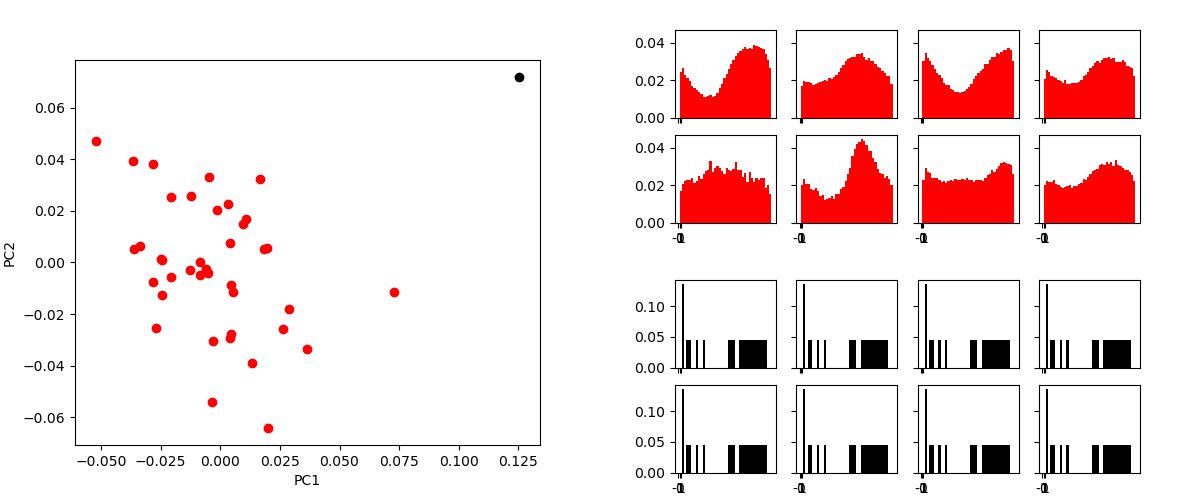

In [89]:
%matplotlib widget
from sklearn.decomposition import PCA
from neuropy import plotting

pca = PCA(n_components=2)
pca.fit(theta_modulation_norm)
projected = pca.fit_transform(theta_modulation_norm)

# figure = plotting.Fig()
# fig,gs = figure.draw(grid=(1,2))
# gs_ = figure.subplot2grid(gs[1],grid=(2,1))
fig = plt.figure(figsize=(12,5))
subfigs = fig.subfigures(1,2,wspace=0.7)
ax_pca = subfigs[0].subplots(1,1)
ax_pca.set_xlabel('PC1')
ax_pca.set_ylabel('PC2')

hist_figs = subfigs[1].subfigures(2,1)

colors =['r','k']
for label in [0,1]:
    indices = kmeans.labels_==label
    ax_pca.scatter(projected[indices,0],projected[indices,1],c=colors[label])

    ind_subset = np.random.choice(np.where(indices)[0],8)
    frate_subset = theta_modulation_norm[ind_subset]
    ax_hists = hist_figs[label].subplots(2,4,sharex=True,sharey=True).reshape(-1)
    for i,f in enumerate(frate_subset):
        ax_hists[i].stairs(f,phase_bin,color=colors[label],fill=True)
        ax_hists[i].set_xticks([-5,0,5])
        ax_hists[i].set_xticklabels([-1,0,1])

# fig.savefig(subjects.figpath_sd/'interneuron_ripple_classification.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
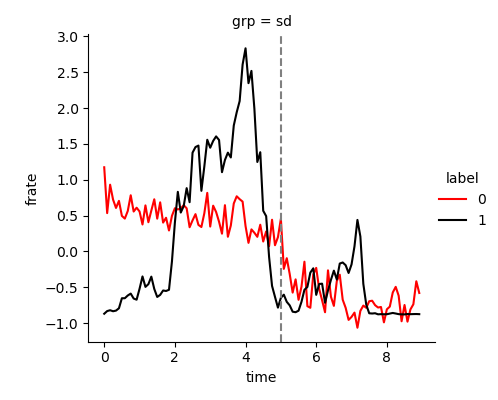

In [3]:
%matplotlib widget
import seaborn as sns

g = sns.relplot(
    data=frate_session_df,
    x="time",
    y="frate",
    hue="label",
    kind="line",
    ci=None,
    col="grp",
    palette=['r','k'],
    height=4,
    aspect=11/10
)

for ax in g.axes.reshape(-1):
    ax.axvline(5,ls='--',color='gray') 
# g.fig.savefig(subjects.figpath_sd/'interneuron_frate_POST_ripple_modulation.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
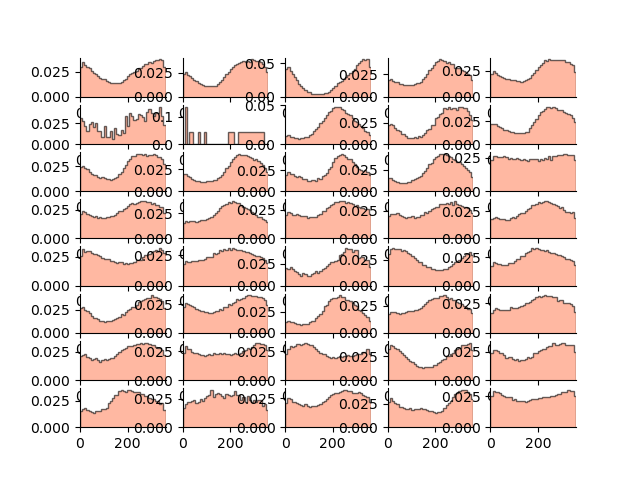

In [28]:
%matplotlib widget
_,axs= plt.subplots(8,5)
axs = axs.reshape(-1)

for i in range(40):
    axs[i].stairs(theta_modulation_norm[i],phase_bin,fill=True,color='#FF8A65',ec='k',alpha=0.6)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].set_xlim([0,360])


# ax.vlines(thresh_arr[:,0],-10000,10000,color='r')
# ax.vlines(thresh_arr[:,1],-10000,10000,color='k')